In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random

# Data Preparation

### Create dataset

In [15]:
# Create datasets

no_dementia_image_paths = os.listdir('/Users/aatyanth/COGS181/data_multiclass_classification/No_Dementia')
mild_dementia_image_paths = os.listdir('/Users/aatyanth/COGS181/data_multiclass_classification/Mild_Dementia')
advanced_dementia_image_paths = os.listdir('/Users/aatyanth/COGS181/data_multiclass_classification/Advanced_Dementia')

patient_ids = []
class_labels = []
image_paths = []
tracker = 0


prefix = '/data_multiclass_classification/Advanced_Dementia/'

for path in advanced_dementia_image_paths:
    patient_id = path.split('_')[1]
    if patient_id not in patient_ids:
        patient_subset = [path for path in advanced_dementia_image_paths if path.split('_')[1] == patient_id]
        chosen = random.sample(patient_subset, k=25)
        tracker += 1
        if tracker > 22:
            break
        for p in chosen:
            image_paths.append(prefix + p)
        for i in range(25):
            patient_ids.append(patient_id)
            class_labels.append(2)
    else:
        continue
    

prefix = '/data_multiclass_classification/Mild_Dementia/'
tracker = 0
for path in mild_dementia_image_paths:
    patient_id = path.split('_')[1]
    if patient_id not in patient_ids:
        patient_subset = [path for path in mild_dementia_image_paths if path.split('_')[1] == patient_id]
        chosen = random.sample(patient_subset, k=25)
        tracker += 1
        if tracker > 22:
            break
        for p in chosen:
            image_paths.append(prefix + p)
        for i in range(25):
            patient_ids.append(patient_id)
            class_labels.append(1)
    else:
        continue
    
prefix = '/data_multiclass_classification/No_Dementia/'
tracker = 0

for path in no_dementia_image_paths:
    patient_id = path.split('_')[1]
    if patient_id not in patient_ids:
        patient_subset = [path for path in no_dementia_image_paths if path.split('_')[1] == patient_id]
        chosen = random.sample(patient_subset, k=25)
        tracker += 1
        if tracker > 22:
            break
        for p in chosen:
            image_paths.append(prefix + p)
        for i in range(25):
            patient_ids.append(patient_id)
            class_labels.append(0)
    else:
        continue

In [16]:
df = pd.DataFrame([patient_ids, image_paths, class_labels]).transpose()
df.columns = ['patient_id', 'image_path', 'class_label']
df

,patient_id,image_path,class_label
0,0308,/data_multiclass_classification/Advanced_Demen...,2
1,0308,/data_multiclass_classification/Advanced_Demen...,2
2,0308,/data_multiclass_classification/Advanced_Demen...,2
3,0308,/data_multiclass_classification/Advanced_Demen...,2
4,0308,/data_multiclass_classification/Advanced_Demen...,2
...,...,...,...
1645,0346,/data_multiclass_classification/No_Dementia/OA...,0
1646,0346,/data_multiclass_classification/No_Dementia/OA...,0
1647,0346,/data_multiclass_classification/No_Dementia/OA...,0
1648,0346,/data_multiclass_classification/No_Dementia/OA...,0


### Train-Test Split (based on random selection of patients done in data_exploration.ipynb)

In [17]:
random.seed(62)
# Create separate dataframes for each class
class_0_df = df[df['class_label'].isin([0])]
class_1_df = df[df['class_label'].isin([1])]
class_2_df = df[df['class_label'].isin([2])]

train_choices_0 = random.sample(class_0_df['patient_id'].unique().tolist(), k=15)
train_choices_1 = random.sample(class_1_df['patient_id'].unique().tolist(), k=15)
train_choices_2 = random.sample(class_2_df['patient_id'].unique().tolist(), k=16)

test_choices_0 = []
for id in class_0_df['patient_id'].unique():
    if (id not in train_choices_0) and (id not in test_choices_0):
        test_choices_0.append(id)
    else:
        continue
test_choices_1 = []
for id in class_1_df['patient_id'].unique():
    if (id not in train_choices_1) and (id not in test_choices_1):
        test_choices_1.append(id)
    else:
        continue
test_choices_2 = []
for id in class_2_df['patient_id'].unique():
    if (id not in train_choices_2) and (id not in test_choices_2):
        test_choices_2.append(id)
    else:
        continue

print("Patient IDs for training set from class 0: ", train_choices_0)
print("Patient IDs for training set from class 1: ", train_choices_1)
print("Patient IDs for training set from class 2: ", train_choices_2)
print()
print("Patient IDs for testing set from class 0: ", test_choices_0)
print("Patient IDs for testing set from class 1: ", test_choices_1)
print("Patient IDs for testing set from class 2: ", test_choices_2)
print()

#Check that train and test sets have no overlapping participants
compare_0 = np.intersect1d(np.array(train_choices_0), np.array(test_choices_0))
if len(compare_0) > 0:
    print('INTERSECTING PATIENT ID\'S')
else:
    print("No intersecting ID\'s")
    
compare_1 = np.intersect1d(np.array(train_choices_1), np.array(test_choices_1))
if len(compare_1) > 0:
    print('INTERSECTING PATIENT ID\'S')
else:
    print("No intersecting ID\'s")

compare_2 = np.intersect1d(np.array(train_choices_2), np.array(test_choices_2))
if len(compare_2) > 0:
    print('INTERSECTING PATIENT ID\'S')
else:
    print("No intersecting ID\'s")
print()

# Create the training set dataframe
train_df = df[df['patient_id'].isin(train_choices_0 + train_choices_1 + train_choices_2)]
train_df = train_df.reset_index()
print("Number of participants in training set: ", int(len(train_df) / 16))

# Create the testing set dataframe
test_df = df[df['patient_id'].isin(test_choices_0 + test_choices_1 + test_choices_2)]
test_df = test_df.reset_index()
print("Number of participants in testing set: ", int(len(test_df) / 16))

print('Train Ratio: ', (len(train_df) / len(df)))
print('Test Ratio: ', (len(test_df) / len(df)))

Patient IDs for training set from class 0:  ['0214', '0055', '0234', '0229', '0026', '0096', '0356', '0213', '0322', '0369', '0275', '0349', '0132', '0050', '0317']
Patient IDs for training set from class 1:  ['0023', '0263', '0243', '0267', '0098', '0042', '0179', '0161', '0240', '0298', '0233', '0339', '0120', '0003', '0307']
Patient IDs for training set from class 2:  ['0031', '0028', '0053', '0035', '0073', '0056', '0308', '0278', '0134', '0122', '0223', '0316', '0291', '0185', '0268', '0351']

Patient IDs for testing set from class 0:  ['0182', '0144', '0146', '0141', '0068', '0330', '0346']
Patient IDs for testing set from class 1:  ['0286', '0115', '0380', '0084', '0287', '0022', '0039']
Patient IDs for testing set from class 2:  ['0137', '0382', '0052', '0373', '0269', '0067']

No intersecting ID's
No intersecting ID's
No intersecting ID's

Number of participants in training set:  71
Number of participants in testing set:  31
Train Ratio:  0.696969696969697
Test Ratio:  0.30303

# Data Pipeline

### Defining Transforms

In [35]:
# Importing the custom dataset class
from base_classifiers.alzheimers_dataset import alzheimers_dataset
import torchvision.transforms as tf

In [39]:
# Simple transforms for baseline model
def repeat(x):
    return x.repeat(3, 1, 1)

transforms = tf.Compose([
    tf.Pad([0, 124,]),
    tf.ToTensor(),
    torchvision.transforms.Lambda(repeat),
    tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [44]:
# Create datasets based on custom dataset class
root_dir = '/Users/aatyanth/COGS181'

train_image_paths = train_df['image_path'].to_numpy()
train_labels = train_df['class_label'].to_numpy()
train_set = alzheimers_dataset(root_dir=root_dir, image_paths=train_image_paths, labels=train_labels, transform=transforms)
test_image_paths = test_df['image_path'].to_numpy()
test_labels = test_df['class_label'].to_numpy()
test_set = alzheimers_dataset(root_dir=root_dir, image_paths=test_image_paths, labels=test_labels, transform=transforms)

# Set up DataLoaders for train and test set
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True, num_workers=0, drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


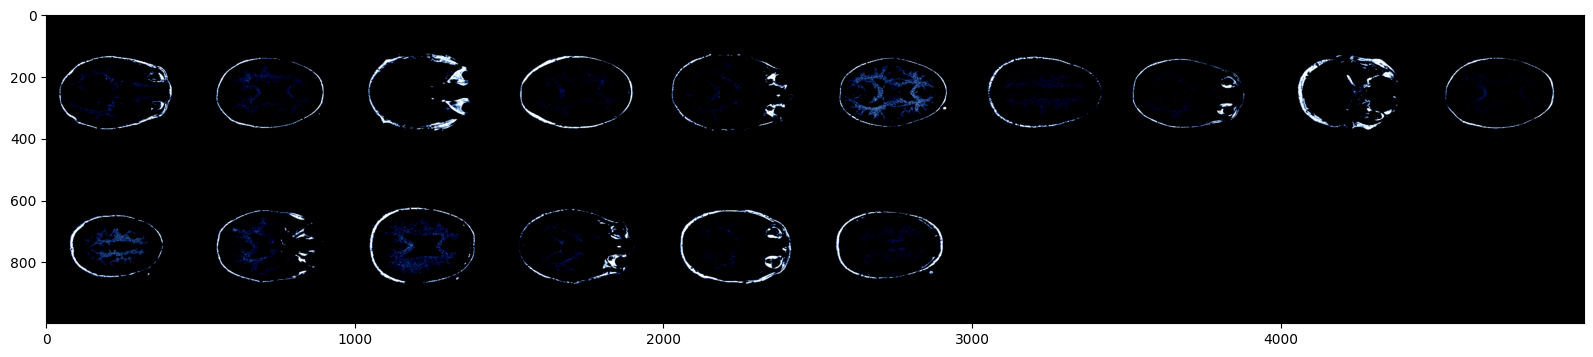

Advanced Alzheimers   Mild Alzheimers   No Alzheimers   No Alzheimers   Mild Alzheimers   No Alzheimers   No Alzheimers   No Alzheimers   Mild Alzheimers   Mild Alzheimers


In [45]:
# Test how the images look

# Function to show image
def show_image(img):
    img = img.numpy()
    plt.figure(figsize=(20, 4))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

iteration = iter(train_loader)
images, labels = next(iteration)

show_image(torchvision.utils.make_grid(images, nrow=10))
classes = ("No Alzheimers", "Mild Alzheimers", "Advanced Alzheimers")
print("   ".join('%5s' % classes[labels[j]] for j in range(10)))


# Model Implementation

### Implement AlzheimersNet Class

In [48]:
from torchvision.models import resnet18, ResNet18_Weights

In [51]:
class AlzheimersResNet(nn.Module):
    
    def __init__(self):
        super(AlzheimersResNet, self).__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, 3)
        
    def forward(self, x):
        return self.model(x)

# Training Implementation

In [52]:
# Choose the device
device = torch.device("cuda0" if torch.cuda.is_available() else "cpu")

# Create an instance of the Network
cnn = AlzheimersResNet()

# Loss and optimizer to use
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)

# Moving network parameters to the chosen device
cnn.to(device)

AlzheimersResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [53]:
from tqdm import tqdm
# Training Procedure

avg_losses = []
epochs = 10
print_freq = 10
predictions_list = []

for epoch in tqdm(range(epochs), desc="Training Completion"):
    running_loss = 0.0
    for batch, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zeroing the gradients
        optimizer.zero_grad()
        
        # Generate predictions
        outputs = cnn(inputs)
        
        # Compute loss based on predictions and ground truth
        loss = loss_func(outputs, labels)
        
        # Take backwards step
        loss.backward()
        
        # Update the network parameters
        optimizer.step()
        
        running_loss += loss.item()
        
        if batch % print_freq == print_freq - 1:
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, batch, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Training Complete.')

Training Completion:   0%|          | 0/10 [00:00<?, ?it/s]

[epoch: 0, i:     9] avg mini-batch loss: 1.454
[epoch: 0, i:    19] avg mini-batch loss: 1.612
[epoch: 0, i:    29] avg mini-batch loss: 0.772
[epoch: 0, i:    39] avg mini-batch loss: 0.659
[epoch: 0, i:    49] avg mini-batch loss: 0.688
[epoch: 0, i:    59] avg mini-batch loss: 0.792
[epoch: 0, i:    69] avg mini-batch loss: 0.656


Training Completion:  10%|█         | 1/10 [04:42<42:20, 282.24s/it]

[epoch: 1, i:     9] avg mini-batch loss: 0.698
[epoch: 1, i:    19] avg mini-batch loss: 0.424
[epoch: 1, i:    29] avg mini-batch loss: 0.529
[epoch: 1, i:    39] avg mini-batch loss: 0.488
[epoch: 1, i:    49] avg mini-batch loss: 0.501
[epoch: 1, i:    59] avg mini-batch loss: 0.649
[epoch: 1, i:    69] avg mini-batch loss: 0.669


Training Completion:  20%|██        | 2/10 [09:56<40:08, 301.07s/it]

[epoch: 2, i:     9] avg mini-batch loss: 0.552
[epoch: 2, i:    19] avg mini-batch loss: 0.339
[epoch: 2, i:    29] avg mini-batch loss: 0.180
[epoch: 2, i:    39] avg mini-batch loss: 0.190
[epoch: 2, i:    49] avg mini-batch loss: 0.324
[epoch: 2, i:    59] avg mini-batch loss: 0.143
[epoch: 2, i:    69] avg mini-batch loss: 0.051


Training Completion:  30%|███       | 3/10 [28:18<1:17:49, 667.02s/it]

[epoch: 3, i:     9] avg mini-batch loss: 0.154
[epoch: 3, i:    19] avg mini-batch loss: 0.136
[epoch: 3, i:    29] avg mini-batch loss: 0.154
[epoch: 3, i:    39] avg mini-batch loss: 0.247
[epoch: 3, i:    49] avg mini-batch loss: 0.245
[epoch: 3, i:    59] avg mini-batch loss: 0.239
[epoch: 3, i:    69] avg mini-batch loss: 0.257


Training Completion:  40%|████      | 4/10 [37:04<1:01:06, 611.14s/it]

[epoch: 4, i:     9] avg mini-batch loss: 0.316
[epoch: 4, i:    19] avg mini-batch loss: 0.156
[epoch: 4, i:    29] avg mini-batch loss: 0.108
[epoch: 4, i:    39] avg mini-batch loss: 0.172
[epoch: 4, i:    49] avg mini-batch loss: 0.130
[epoch: 4, i:    59] avg mini-batch loss: 0.110
[epoch: 4, i:    69] avg mini-batch loss: 0.178


Training Completion:  50%|█████     | 5/10 [46:07<48:53, 586.71s/it]  

[epoch: 5, i:     9] avg mini-batch loss: 0.129
[epoch: 5, i:    19] avg mini-batch loss: 0.151
[epoch: 5, i:    29] avg mini-batch loss: 0.127
[epoch: 5, i:    39] avg mini-batch loss: 0.056
[epoch: 5, i:    49] avg mini-batch loss: 0.080
[epoch: 5, i:    59] avg mini-batch loss: 0.074
[epoch: 5, i:    69] avg mini-batch loss: 0.039


Training Completion:  60%|██████    | 6/10 [51:30<33:07, 496.90s/it]

[epoch: 6, i:     9] avg mini-batch loss: 0.036
[epoch: 6, i:    19] avg mini-batch loss: 0.062
[epoch: 6, i:    29] avg mini-batch loss: 0.035
[epoch: 6, i:    39] avg mini-batch loss: 0.023
[epoch: 6, i:    49] avg mini-batch loss: 0.013
[epoch: 6, i:    59] avg mini-batch loss: 0.038
[epoch: 6, i:    69] avg mini-batch loss: 0.064


Training Completion:  70%|███████   | 7/10 [57:02<22:09, 443.01s/it]

[epoch: 7, i:     9] avg mini-batch loss: 0.052
[epoch: 7, i:    19] avg mini-batch loss: 0.016
[epoch: 7, i:    29] avg mini-batch loss: 0.037
[epoch: 7, i:    39] avg mini-batch loss: 0.036
[epoch: 7, i:    49] avg mini-batch loss: 0.125
[epoch: 7, i:    59] avg mini-batch loss: 0.084
[epoch: 7, i:    69] avg mini-batch loss: 0.051


Training Completion:  80%|████████  | 8/10 [1:02:42<13:40, 410.10s/it]

[epoch: 8, i:     9] avg mini-batch loss: 0.010
[epoch: 8, i:    19] avg mini-batch loss: 0.012
[epoch: 8, i:    29] avg mini-batch loss: 0.093
[epoch: 8, i:    39] avg mini-batch loss: 0.087
[epoch: 8, i:    49] avg mini-batch loss: 0.057
[epoch: 8, i:    59] avg mini-batch loss: 0.124
[epoch: 8, i:    69] avg mini-batch loss: 0.071


Training Completion:  90%|█████████ | 9/10 [1:08:22<06:28, 388.17s/it]

[epoch: 9, i:     9] avg mini-batch loss: 0.028
[epoch: 9, i:    19] avg mini-batch loss: 0.081
[epoch: 9, i:    29] avg mini-batch loss: 0.086
[epoch: 9, i:    39] avg mini-batch loss: 0.056
[epoch: 9, i:    49] avg mini-batch loss: 0.128
[epoch: 9, i:    59] avg mini-batch loss: 0.373
[epoch: 9, i:    69] avg mini-batch loss: 0.172


Training Completion: 100%|██████████| 10/10 [1:14:07<00:00, 444.72s/it]

Training Complete.


### Training Loss Curve

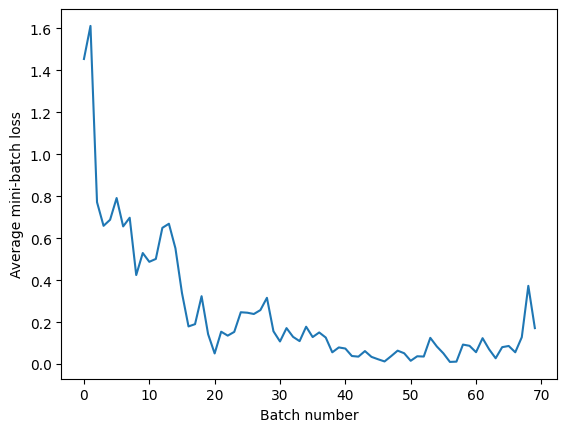

In [54]:
plt.plot(avg_losses)
plt.xlabel("Batch number")
plt.ylabel("Average mini-batch loss")
plt.show()

# Evaluation

In [55]:
# Test Accuracy

total_samples = 0
correct_predictions = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = cnn(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total_samples += labels.size(0)
        
        correct_predictions += (predicted == labels).sum().item()
        
        

print("Accuracy of the Network on Test Data: ", (100 * (correct_predictions/total_samples)))

Accuracy of the Network on Test Data:  47.78225806451613


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


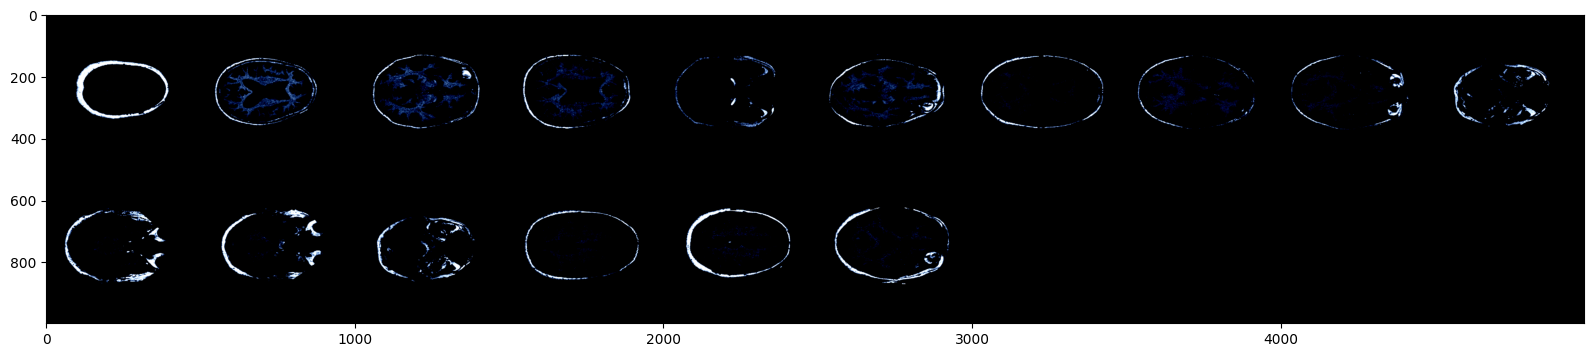

Predictions:   No Alzheimers Advanced Alzheimers Advanced Alzheimers Mild Alzheimers Advanced Alzheimers Advanced Alzheimers Mild Alzheimers No Alzheimers No Alzheimers Advanced Alzheimers
Ground Truth:  Mild Alzheimers Advanced Alzheimers Mild Alzheimers Advanced Alzheimers Mild Alzheimers Mild Alzheimers Advanced Alzheimers No Alzheimers No Alzheimers Mild Alzheimers


In [56]:
# Visualize a few predictions
iteration = iter(test_loader)
images, labels = next(iteration)
images, labels = next(iteration)
show_image(torchvision.utils.make_grid(images, nrow=10))
outputs = cnn(images.to(device))
_, predictions = torch.max(outputs.data, 1)
classes = ("No Alzheimers", "Mild Alzheimers", "Advanced Alzheimers")
print("Predictions:  ", " ".join('%5s' % classes[predictions[i]] for i in range(10)))
print("Ground Truth: ", " ".join('%5s' % classes[labels[j]] for j in range(10)))

In [57]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of No Alzheimers : 62 %
Accuracy of Mild Alzheimers : 26 %
Accuracy of Advanced Alzheimers : 51 %
